In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.stats import skewnorm, kstest
from scipy.stats import linregress
import string
import cartopy
import cartopy.crs as ccrs
from scipy.stats import pearsonr
import pandas as pd
from importlib import reload
pd.set_option("mode.chained_assignment", None)
import tools
reload(tools)

dep_l = pickle.load(open('../pickles/line_depths_dict.p','rb'))

In [2]:
transect_count = 0

win_list = []
sum_list = []

dates = []

for key in dep_l:
    
    station = dep_l[key]
    
    for date in station:
        
        dates.append((key,date))

        transect_count += 1

        series = np.array(list(station[date]))

        n_series = (series - np.nanmean(series))

        std = np.nanstd(n_series)

        ns_series = n_series/std
        
        
        if date.month in [10,11,12,1,2,3]:
            win_list.append({'std':std,
                         'mean':np.nanmean(series),
                         'norm':ns_series,
                        })
        else:
            sum_list.append({'std':std,
                         'mean':np.nanmean(series),
                         'norm':ns_series,
                            })

win_df = pd.DataFrame(win_list)
sum_df = pd.DataFrame(sum_list)
all_df = pd.DataFrame(win_list + sum_list)

pickle.dump(all_df, open('../pickles/NP_df.p','wb'))

all_df = pickle.load(open('../pickles/NP_df.p','rb'))

all_statistics = tools.get_statistics(all_df)
print(all_statistics)

{'a': 2.542562886886376, 'loc': -1.114525560819975, 'scale': 1.4973819434202296, 'CV': 0.41696167189340216, 'n': 33539}


/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  CV = np.linalg.lstsq(np.array(df['mean'])[:, np.newaxis], df['std'])[0][0]


In [3]:
pickle.dump(dates,open('../evaluation_data/dates.p','wb'))

In [4]:
bw = 0.1

bin_edges = np.arange(-2.5,3,bw)

bin_centres = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2

flat = np.concatenate(all_df['norm']).ravel()

flat = flat[~np.isnan(flat)]

p, x = np.histogram(flat,
                    bins=bin_edges,
                    density=True,
                   )

fit = skewnorm.pdf(bin_centres,all_statistics['a'],all_statistics['loc'],all_statistics['scale'])

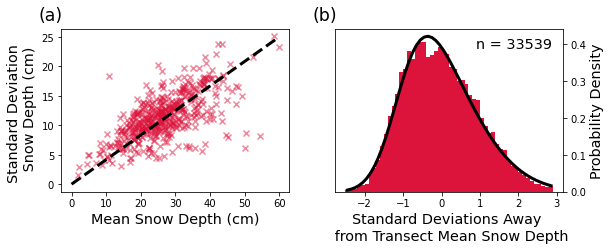

In [5]:
df = all_df

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,3))

ax1.scatter(df['mean'],df['std'],marker='x',color='crimson',alpha=0.5)

ax1.set_xlabel('Mean Snow Depth (cm)', fontsize='x-large')
ax1.set_ylabel('Standard Deviation \n Snow Depth (cm)', fontsize='x-large')

ax1.annotate('(a)', fontsize='xx-large', xy=(-0.1,1.05), xycoords= 'axes fraction')

linear_prediction = np.array([0,np.max(df['mean'])])*all_statistics['CV']

ax1.plot([0,np.max(df['mean'])], linear_prediction, color='k',lw=3, ls='--')

ax2.bar(bin_centres, p, color='crimson',width=0.1)

ax2.plot(bin_centres, fit,color='k',lw=3)

ax2.annotate(f"n = {all_statistics['n']}", xy=(0.95,0.95),xycoords='axes fraction',ha='right',va='top',fontsize='x-large')

ax2.set_ylabel('Probability Density', fontsize='x-large')
ax2.set_xlabel('Standard Deviations Away \n from Transect Mean Snow Depth', fontsize='x-large')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")


ax2.annotate('(b)', fontsize='xx-large', xy=(-0.1,1.05), xycoords= 'axes fraction')

plt.show()

In [6]:
pearsonr(df['mean'],df['std'])

(0.6551816841415519, 1.6232209207820004e-62)

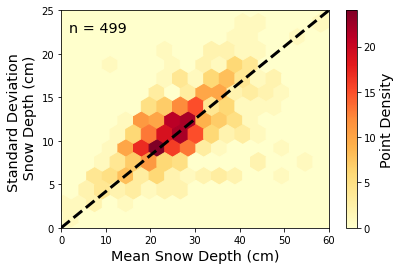

In [7]:
h = plt.hexbin(list(df['mean'])+[-10],list(df['std'])+[-10],gridsize=20,cmap='YlOrRd')

plt.plot([0,np.max(df['mean'])], linear_prediction, color='k',lw=3, ls='--')

cb = plt.colorbar()

cb.set_label('Point Density', fontsize='x-large')

plt.xlabel('Mean Snow Depth (cm)', fontsize='x-large')
plt.ylabel('Standard Deviation \n Snow Depth (cm)', fontsize='x-large')

plt.xlim(0,60)
plt.ylim(0,25)


plt.annotate(f"n = 499", xy=(0.03,0.95),xycoords='axes fraction',ha='left',va='top',fontsize='x-large')

plt.savefig('../figures/fig_S1', bbox_inches='tight',dpi=500)
plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/sup_figs/figS1.png', bbox_inches='tight',dpi=500)

0.9999999999999991
0.9999999999999991


/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  CV = np.linalg.lstsq(np.array(df['mean'])[:, np.newaxis], df['std'])[0][0]
/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  CV = np.linalg.lstsq(np.array(df['mean'])[:, np.newaxis], df['std'])[0][0]
/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input 

Text(0.05, 0.85, 'n = 350')

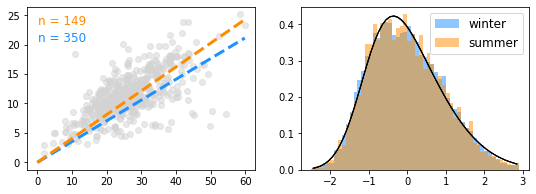

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,3))


fits = {}
statistics = {}

for df, season in zip([all_df, win_df, sum_df], ['all','winter','summer']):
    
    statistics[season] = tools.get_statistics(df)

    bw = 0.1

    bin_edges = np.arange(-2.5,3,bw)

    bin_centres = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2

    flat = np.concatenate(df['norm']).ravel()

    flat = flat[~np.isnan(flat)]

    p, x = np.histogram(flat,
                        bins=bin_edges,
                        density=True,
                       )

    fit = skewnorm.pdf(bin_centres,
                       statistics[season]['a'],
                       statistics[season]['loc'],
                       statistics[season]['scale'])
    
    fits[season] = {'fit':fit,
                    'flat':flat,
                    'bin_centres':bin_centres,
                    'p':p}
    
    if season in ['winter','summer']:
        
        color = 'dodgerblue' if season == 'winter' else 'darkorange'
        
        ax1.scatter(df['mean'],df['std'],color='lightgray', marker='o', alpha=0.5)
        
        linear_prediction = np.array([0,np.max(df['mean'])])*statistics[season]['CV']

        ax1.plot([0,np.max(all_df['mean'])], linear_prediction, color=color,lw=3, ls='--')
        
        ax2.bar(fits[season]['bin_centres'], fits[season]['p'],color=color,alpha=0.5,width=0.1,label=season)
        
        print(np.sum(np.multiply(0.1, fits[season]['p'])))
        
    ax2.plot(fits[season]['bin_centres'], fits[season]['fit'],color='k',lw=1)
    
ax2.legend(fontsize='large')
    
ax1.annotate(f"n = {len(sum_list)}", xy = (0.05, 0.95),
             xycoords='axes fraction', va = 'top', fontsize='large',color='darkorange')
ax1.annotate(f"n = {len(win_list)}", xy = (0.05, 0.85),
             xycoords='axes fraction', va = 'top', fontsize='large',color='dodgerblue')

# plt.savefig('../figures/fig1b.png', bbox_inches='tight',dpi=500)
# plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/fig1b.png', bbox_inches='tight',dpi=500)

/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  CV = np.linalg.lstsq(np.array(df['mean'])[:, np.newaxis], df['std'])[0][0]
/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  CV = np.linalg.lstsq(np.array(df['mean'])[:, np.newaxis], df['std'])[0][0]
/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input 

0.9999999999999991
0.9999999999999991


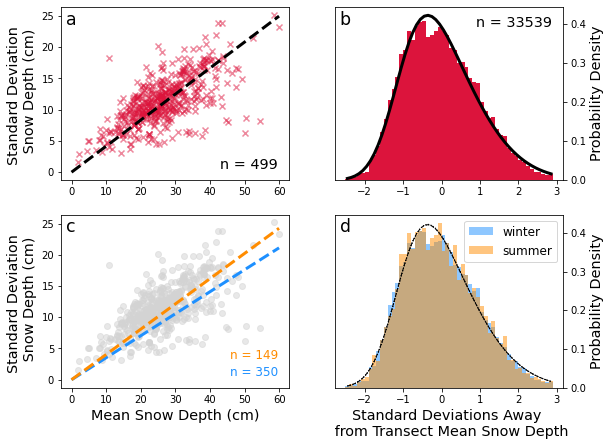

In [14]:
df = all_df

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,7))

ax1.scatter(df['mean'],df['std'],marker='x',color='crimson',alpha=0.5)
ax1.annotate(f"n = 499", xy=(0.95,0.05),xycoords='axes fraction',
             ha='right',va='bottom',fontsize='x-large')


ax3.set_xlabel('Mean Snow Depth (cm)', fontsize='x-large')
ax1.set_ylabel('Standard Deviation \n Snow Depth (cm)', fontsize='x-large')
ax3.set_ylabel('Standard Deviation \n Snow Depth (cm)', fontsize='x-large')

linear_prediction = np.array([0,np.max(df['mean'])])*all_statistics['CV']

ax1.plot([0,np.max(df['mean'])], linear_prediction, color='k',lw=3, ls='--')

ax2.bar(bin_centres, fits['all']['p'], color='crimson',width=0.1)

ax2.plot(bin_centres, fit,color='k',lw=3)

ax2.annotate(f"n = {all_statistics['n']}", xy=(0.95,0.95),xycoords='axes fraction',ha='right',va='top',fontsize='x-large')

ax2.set_ylabel('Probability Density', fontsize='x-large')
ax4.set_ylabel('Probability Density', fontsize='x-large')

ax4.set_xlabel('Standard Deviations Away \n from Transect Mean Snow Depth', fontsize='x-large')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

######################################################################

for df, season in zip([all_df, win_df, sum_df], ['all','winter','summer']):
    
    statistics[season] = tools.get_statistics(df)

    bw = 0.1

    bin_edges = np.arange(-2.5,3,bw)

    bin_centres = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2

    if season in [
        'winter',
        'summer']:
        
        color = 'dodgerblue' if season == 'winter' else 'darkorange'
        
        ax3.scatter(df['mean'],df['std'],color='lightgray', marker='o', alpha=0.5)
        
        linear_prediction = np.array([0,np.max(df['mean'])])*statistics[season]['CV']

        ax3.plot([0,np.max(all_df['mean'])], linear_prediction, color=color,lw=3, ls='--')
        
        ax4.bar(fits[season]['bin_centres'], fits[season]['p'],color=color,alpha=0.5,width=0.1,label=season)
        
        print(np.sum(np.multiply(0.1, fits[season]['p'])))
    
    ls = '--' if season == 'winter' else ':'
    ax4.plot(fits[season]['bin_centres'], fits[season]['fit'],color='k',lw=1, ls=ls)
    
ax4.legend(fontsize='large')
    
ax3.annotate(f"n = {len(sum_list)}", xy = (0.95, 0.15),
             xycoords='axes fraction', va = 'bottom', ha='right',
             fontsize='large',color='darkorange')
ax3.annotate(f"n = {len(win_list)}", xy = (0.95, 0.05),
             xycoords='axes fraction', va = 'bottom', ha='right',
             fontsize='large',color='dodgerblue')


ax1.annotate('a', fontsize='xx-large', xy=(0.02,0.98), va='top',
             xycoords= 'axes fraction')
ax2.annotate('b', fontsize='xx-large', xy=(0.02,0.98), va='top',
             xycoords= 'axes fraction')
ax3.annotate('c', fontsize='xx-large', xy=(0.02,0.98), va='top',
             xycoords= 'axes fraction')
ax4.annotate('d', fontsize='xx-large', xy=(0.02,0.98), va='top',
             xycoords= 'axes fraction')



plt.savefig('../figures/fig_3.png', bbox_inches='tight',dpi=500)
plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/figs/fig3.png', bbox_inches='tight',dpi=500)

plt.show()

In [13]:
pickle.dump(statistics, open('../pickles/statistics.p','wb'))

In [14]:
fits['winter']['fit'], fits['summer']['fit']

(array([0.00421788, 0.00686689, 0.01084751, 0.01663143, 0.02475708,
        0.03579296, 0.05028068, 0.06866085, 0.09118954, 0.11785811,
        0.14833154, 0.18192042, 0.21759742, 0.25406181, 0.28984637,
        0.32345204, 0.35348971, 0.37880691, 0.39858031, 0.41236228,
        0.42007911, 0.42198711, 0.41859953, 0.41059981, 0.39875601,
        0.38384777, 0.36661198, 0.34770891, 0.32770653, 0.30707873,
        0.28621247, 0.26541936, 0.24494839, 0.22499753, 0.2057234 ,
        0.18724875, 0.1696679 , 0.15305081, 0.13744608, 0.1228833 ,
        0.1093752 , 0.09691951, 0.08550083, 0.07509248, 0.0656583 ,
        0.05715444, 0.04953105, 0.04273386, 0.03670574, 0.03138795,
        0.0267214 , 0.02264762, 0.01910966, 0.0160528 ]),
 array([0.00409299, 0.00667731, 0.01056953, 0.01623782, 0.02421904,
        0.03508326, 0.0493779 , 0.06755415, 0.08988349, 0.11637637,
        0.14671867, 0.18024091, 0.21593166, 0.25249935, 0.28847718,
        0.32235719, 0.35273295, 0.37842845, 0.39859374, 0.

In [21]:
kstest(fits['winter']['flat'], fits['summer']['flat'])

KstestResult(statistic=0.012074835909685333, pvalue=0.2407305793242258)

# Do some simple, illustrative calculations:

sigma = 0.2085
Probability >1m
0.01816506702231498
Probability <0.3m
0.1661428121160569


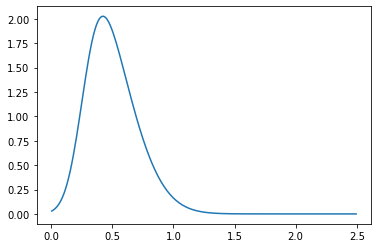

In [16]:
mean_depth = 0.5

bc, dep_dist = tools.depth_distribution_from_depth(mean_depth,
                                                   dep_bin_edges=np.linspace(0,2.5,200),
                                                   statistics=statistics['all'])

sigma = 0.417 * mean_depth

print(f'sigma = {sigma}')

bin_width = np.diff(bc)[0]

plt.plot(bc, dep_dist/bin_width)



print('Probability >1m')
print(np.sum(dep_dist[bc>1.0]))
print('Probability <0.3m')
print(np.sum(dep_dist[bc<0.3]))

0.023327897203399513


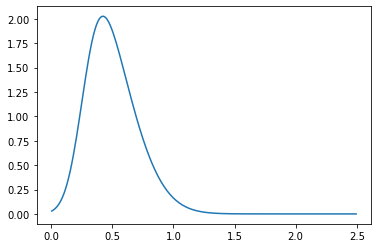

In [17]:
md = 0.5

bc, dep_dist = tools.depth_distribution_from_depth(md,dep_bin_edges=np.linspace(0,2.5,200),statistics=statistics['all'])

bin_width = np.diff(bc)[0]

plt.plot(bc, dep_dist/bin_width)


print(np.sum(dep_dist[bc<0.15]))

0.16600815553828668


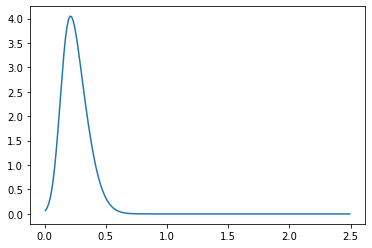

In [34]:
bc, dep_dist = tools.depth_distribution_from_depth(0.25,dep_bin_edges=np.linspace(0,2.5,200),statistics=statistics['all'])

bin_width = np.diff(bc)[0]

plt.plot(bc, dep_dist/bin_width)


print(np.sum(dep_dist[bc<0.15]))